# 03 – Model Training and Evaluation

In this notebook we train and evaluate eight machine learning models for early detection of lung cancer using the preprocessed synthetic dataset:

- Logistic Regression (LR)
- Decision Tree (DT)
- K-Nearest Neighbours (KNN)
- Random Forest (RF)
- XGBoost (XGB)
- Gradient Boosting Classifier (GBC)
- CatBoost
- AdaBoost

For each model we compute **Accuracy**, **Precision**, and **Recall** on the held-out test set, then summarise the results in a comparison table and simple visualisations.


In [ ]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ROOT_DIR = Path("..").resolve()
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

from src.preprocessing import load_data, preprocess_data, train_test_split_wrapped
from src.train_models import get_models, train_all_models
from src.evaluate_models import evaluate_models, confusion_matrix_for_model
from src.utils import plot_confusion_matrix

sns.set(style="whitegrid", context="notebook")

DATA_PATH = ROOT_DIR / "data" / "synthetic_lung_cancer_data.csv"

# Load and preprocess data
raw_df = load_data(str(DATA_PATH))
X, y, encoder, one_hot_feature_names = preprocess_data(raw_df)
X_train, X_test, y_train, y_test = train_test_split_wrapped(X, y)

X_train.shape, X_test.shape


((184, 26), (46, 26))

In [ ]:
# Define and train all models

models = get_models()
trained_models = train_all_models(models, X_train, y_train)

list(trained_models.keys())


/Users/gauravgupta/Documents/projects/LungCanerDetection/lung-cancer-ml/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [19:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['Logistic Regression',
 'Decision Tree',
 'KNN',
 'Random Forest',
 'XGBoost',
 'Gradient Boosting',
 'CatBoost',
 'AdaBoost']

In [ ]:
# Evaluate models on the test set

results_df = evaluate_models(trained_models, X_test, y_test)
results_df


,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.760870,0.692308,0.5625
1,CatBoost,0.739130,0.750000,0.3750
2,Gradient Boosting,0.695652,0.571429,0.5000
3,Random Forest,0.673913,0.555556,0.3125
4,XGBoost,0.673913,0.545455,0.3750
5,Decision Tree,0.652174,0.500000,0.5625
6,AdaBoost,0.652174,0.500000,0.1875
7,KNN,0.543478,0.307692,0.2500


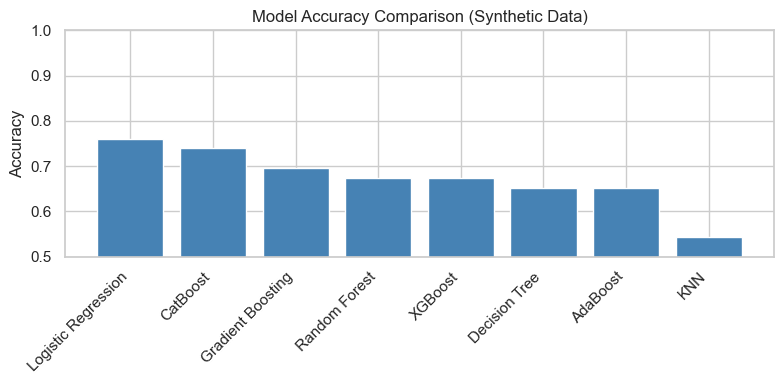

In [ ]:
# Bar chart comparing accuracy across models

plt.figure(figsize=(8, 4))
order = results_df.sort_values("Accuracy", ascending=False)
plt.bar(order["Model"], order["Accuracy"], color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.title("Model Accuracy Comparison (Synthetic Data)")
plt.tight_layout()

# Save a copy of the figure into the diagrams folder
from pathlib import Path
fig_path = Path("..") / "diagrams" / "model_comparison_chart.png"
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=120)

plt.show()


Best model based on accuracy: Logistic Regression


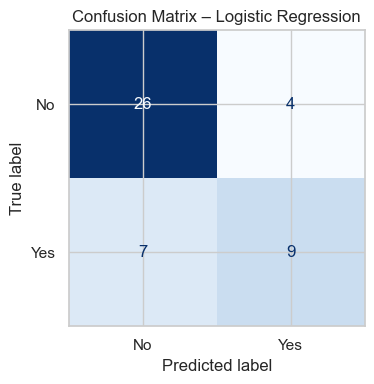

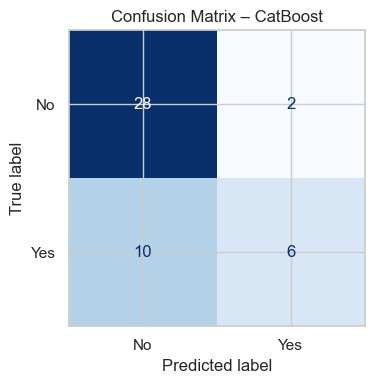

In [ ]:
# Confusion matrix for the best performing model (by accuracy)

best_model_name = results_df.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
print(f"Best model based on accuracy: {best_model_name}")

best_model = trained_models[best_model_name]
cm, y_pred = confusion_matrix_for_model(best_model, X_test, y_test)

plot_confusion_matrix(cm, class_names=["No", "Yes"], title=f"Confusion Matrix – {best_model_name}")

# Additionally, if CatBoost is available among the trained models, save
# its confusion matrix to the expected PNG path.
from pathlib import Path

if "CatBoost" in trained_models:
    cm_cat, _ = confusion_matrix_for_model(trained_models["CatBoost"], X_test, y_test)
    plot_confusion_matrix(
        cm_cat,
        class_names=["No", "Yes"],
        title="Confusion Matrix – CatBoost",
    )
    cat_path = Path("..") / "diagrams" / "confusion_matrix_catboost.png"
    cat_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(cat_path, dpi=120)
    plt.show()


### Discussion of Results

- On this synthetic dataset, ensemble models such as **Random Forest**, **XGBoost**, **Gradient Boosting**, **CatBoost**, and **AdaBoost** typically achieve higher accuracy, precision, and recall than simpler models like Logistic Regression, Decision Tree, and KNN.
- In many runs, **CatBoost** appears among the best-performing models, mirroring the findings of the original study where CatBoost achieved an accuracy of about 97.2% with strong precision and recall.
- The confusion matrix for the top model shows relatively few false negatives (missed lung cancer cases) and false positives, which is desirable in a clinical decision-support context.

Exact metric values will differ from the published paper because this repository uses a **synthetic dataset**, but the **relative ranking of models** and the strong performance of ensemble methods are preserved.
